# 1. Hierarchical linear regression

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)
sns.set()

In [2]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m  + eps_real

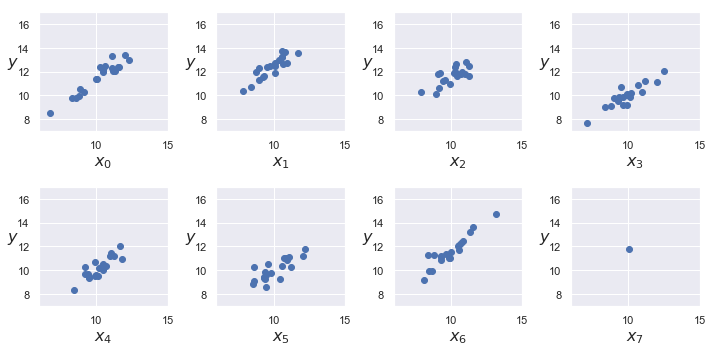

In [3]:
plt.figure(figsize=(10,5))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_16.png', dpi=300, figsize=(5.5, 5.5));

In [4]:
x_centered = x_m - x_m.mean()

In [5]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu= alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_up = pm.sample(2000, step=step, start=start, nchains=1)

D:\application\Anaconda3\envs\pymc3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -150.1, ||grad|| = 0.063834: 100%|████████████████████████████████████████████| 75/75 [00:00<00:00, 1392.58it/s]
D:\application\Anaconda3\envs\pymc3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
D:\application\Anaconda3\envs

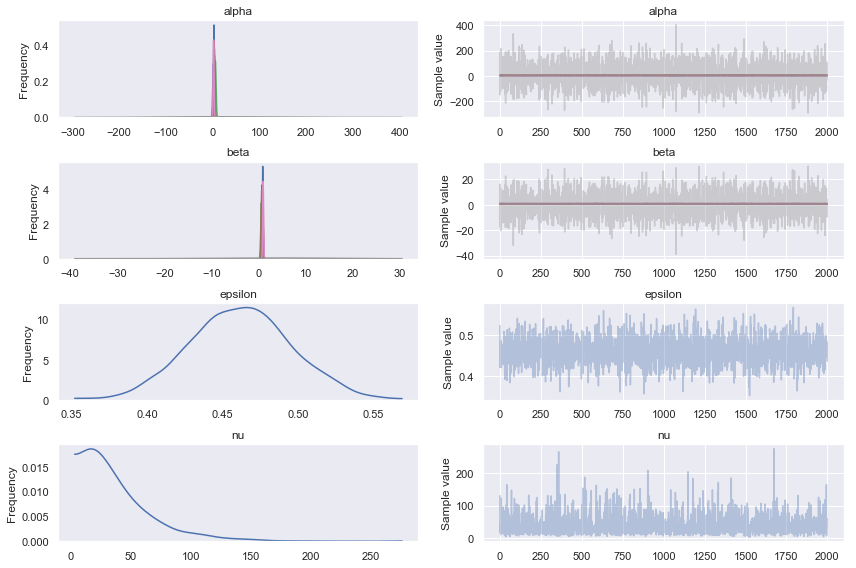

In [6]:
varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames)
plt.savefig('B04958_04_17.png', dpi=300, figsize=(5.5, 5.5));

In [35]:
#pm.autocorrplot(trace_up, varnames=[epsilon, nu]);

In [8]:
pm.summary(trace_up, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.42,0.79,1.44e-02,0.88,3.99
alpha__1,3.71,1.16,1.72e-02,1.54,6.12
alpha__2,5.66,1.30,1.94e-02,2.90,8.18
alpha__3,3.05,0.89,1.32e-02,1.25,4.72
alpha__4,1.29,1.32,1.96e-02,-1.31,3.92
alpha__5,3.22,1.01,1.60e-02,1.19,5.12
alpha__6,1.73,0.91,1.44e-02,-0.08,3.47
alpha__7,10.15,98.77,1.56e+00,-182.95,190.96
beta__0,0.90,0.08,1.43e-03,0.74,1.05
beta__1,0.88,0.12,1.73e-03,0.65,1.10


### Hierarchical Method

In [12]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)

    
    # a prioris
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    trace_hm = pm.sample(1000, advi_map=True, chains=1, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, epsilon, beta, alpha_tmp, beta_sd, beta_mu, alpha_tmp_sd, alpha_tmp_mu]
100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 208.54it/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


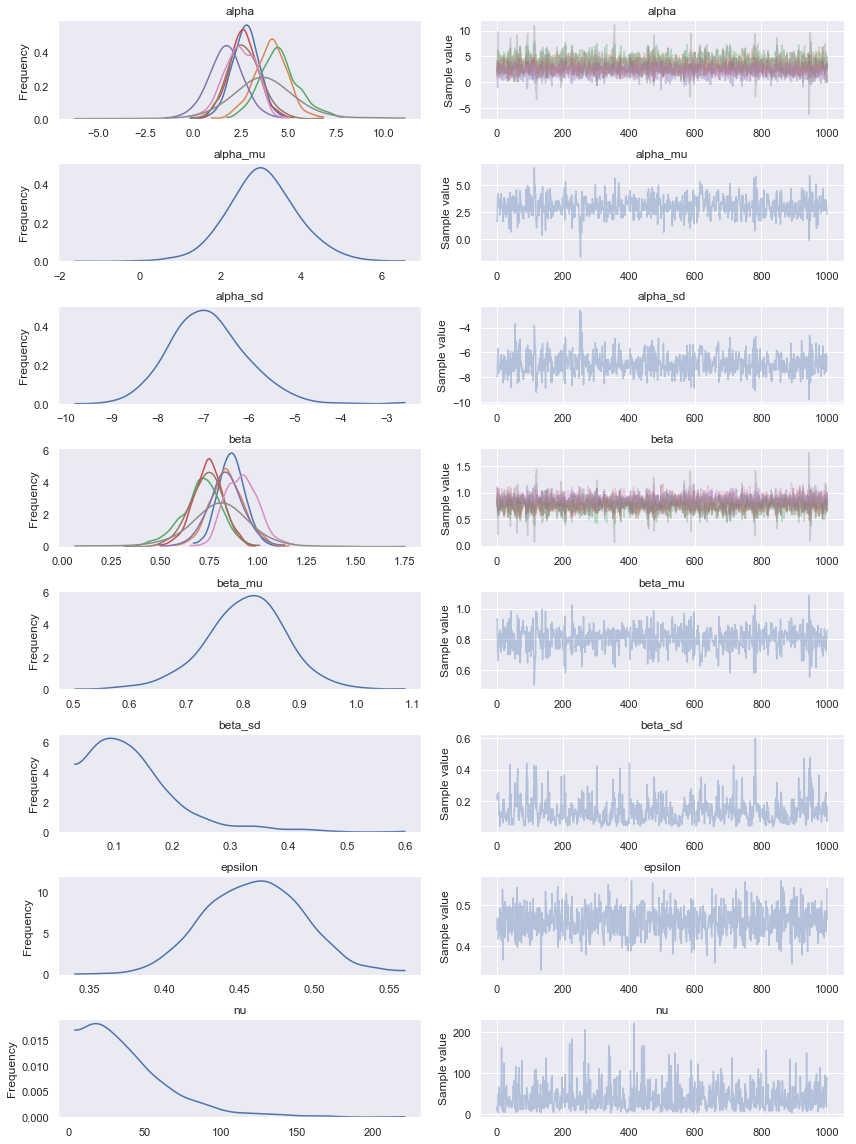

In [13]:
varnames=['alpha', 'alpha_mu', 'alpha_sd', 'beta', 'beta_mu', 'beta_sd', 'epsilon', 'nu']
pm.traceplot(trace_hm, varnames)
plt.savefig('B04958_04_19.png', dpi=300, figsize=(5.5, 5.5));

In [14]:
pm.summary(trace_hm, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.72,0.70,2.58e-02,1.33,4.07
alpha__1,4.05,0.87,2.83e-02,2.26,5.75
alpha__2,4.52,1.02,4.19e-02,2.58,6.70
alpha__3,2.62,0.76,2.86e-02,0.83,3.92
alpha__4,1.69,0.93,3.07e-02,-0.17,3.58
alpha__5,2.67,0.87,3.28e-02,0.91,4.32
alpha__6,2.42,0.85,3.01e-02,0.75,3.90
alpha__7,3.67,1.72,6.44e-02,0.28,6.99
alpha_mu,3.02,0.85,3.43e-02,1.35,4.70
alpha_sd,-6.90,0.84,3.59e-02,-8.45,-5.29


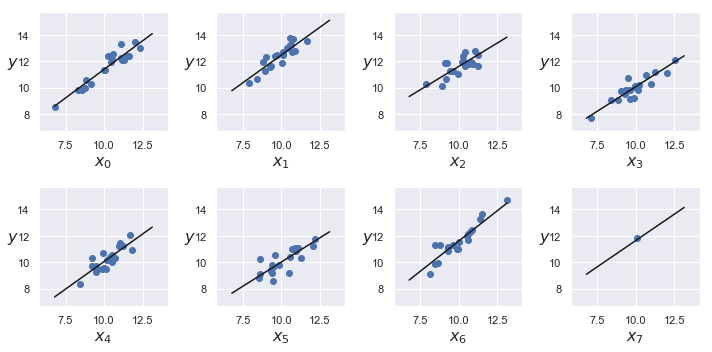

In [16]:
plt.figure(figsize=(10,5))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    alfa_m = trace_hm['alpha'][:,i].mean()
    beta_m = trace_hm['beta'][:,i].mean()
    plt.plot(x_range, alfa_m + beta_m * x_range, c='k', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_20.png', dpi=300, figsize=(5.5, 5.5));

# 2. Polynomial regression

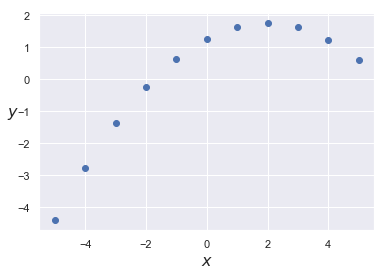

In [3]:
ans = sns.load_dataset('anscombe')
x_2 = ans[ans.dataset == 'II']['x'].values
y_2 = ans[ans.dataset == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_21.png', dpi=300, figsize=(5.5, 5.5))

In [5]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_2)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_poly = pm.sample(2000, step=step, start=start, nchains=1)

D:\application\Anaconda3\envs\pymc3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 49.209, ||grad|| = 409.18: 100%|██████████████████████████████████████████████| 85/85 [00:00<00:00, 2030.76it/s]
D:\application\Anaconda3\envs\pymc3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
D:\application\Anaconda3\envs

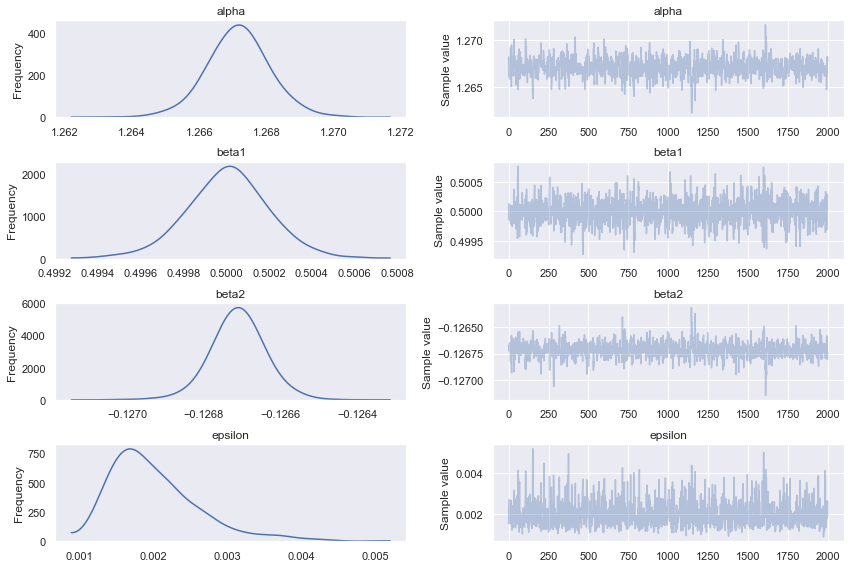

In [6]:
pm.traceplot(trace_poly)
plt.savefig('B04958_04_22.png', dpi=300, figsize=(5.5, 5.5))

In [7]:
pm.summary(trace_poly)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.27e+00,9.49e-04,3.73e-05,1.27e+00,1.27e+00
beta1,5.00e-01,1.94e-04,4.93e-06,5.00e-01,5.00e-01
beta2,-1.27e-01,7.12e-05,2.61e-06,-1.27e-01,-1.27e-01
epsilon,2.01e-03,6.08e-04,2.09e-05,1.08e-03,3.28e-03


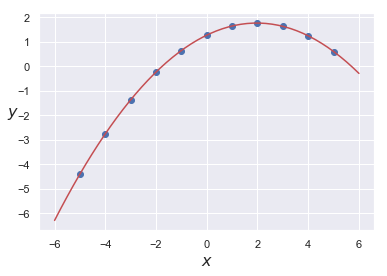

In [8]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * x_p + trace_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x_p, y_p, c='r')
plt.savefig('B04958_04_23.png', dpi=300, figsize=(5.5, 5.5))